Batch Normalization, 和普通的数据标准化类似, 是将分散的数据统一的一种做法。具有统一规格的数据,能让机器学习更容易学习到数据之中的规律.

每层都做标准化

接近于 1 的部已经处在了 激励函数的饱和阶段, 也就是如果 x 无论再怎么扩大, tanh 激励函数输出值也还是接近1。换句话说,神经网络在初始阶段已经不对那些比较大的 x 特征范围敏感了.

这个不敏感问题不仅仅发生在神经网络的输入层, 而且在隐藏层中也经常会发生

Batch Normalization (BN) 就被添加在每一个全连接和激励函数之间.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(1)
np.random.seed(1)

In [4]:
N_SAMPLES = 2000
BATCH_SIZE = 64
EPOCH = 12
LR = 0.03
N_HIDDEN = 8
ACTIVATION = tf.nn.tanh
B_INIT = tf.constant_initializer(-0.2) # use a bad bias initialization

training data

In [6]:
x = np.linspace(-7, 10, N_SAMPLES)[:, np.newaxis]
np.random.shuffle(x)
noise = np.random.normal(0, 2, x.shape)
y = np.square(x) - 5 + noise
train_data = np.hstack((x, y))

test data

In [7]:
test_x = np.linspace(-7, 10, 200)[:, np.newaxis]
noise = np.random.normal(0, 2, test_x.shape)
test_y = np.square(test_x) - 5 + noise

In [8]:
%matplotlib inline

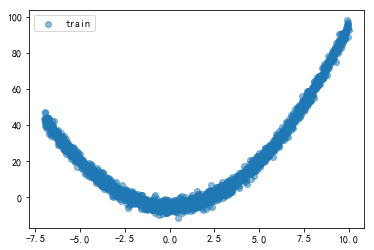

In [10]:
plt.scatter(x, y, alpha=0.5, label="train")
plt.legend(loc="best")

In [11]:
tf_x = tf.placeholder(tf.float32, [None, 1])
tf_y = tf.placeholder(tf.float32, [None, 1])
tf_is_train = tf.placeholder(tf.bool, None)

In [14]:
class NN(object):
    def __init__(self, batch_normalization=False):
        self.is_bn = batch_normalization
        
        self.w_init = tf.random_normal_initializer(0., .1)  # weights initialization
        self.pre_activation = [tf_x]
        if self.is_bn:
            self.layer_input = [tf.layers.batch_normalization(tf_x, training=tf_is_train)]  # for input data
        else:
            self.layer_input = [tf_x]
        
        # adding hidden layers
        for i in range(N_HIDDEN):
            self.layer_input.append(self.add_layer(self.layer_input[-1], 10, ac=ACTIVATION))
        self.out = tf.layers.dense(self.layer_input[-1], 1, kernel_initializer=self.w_init, bias_initializer=B_INIT)
        self.loss = tf.losses.mean_squared_error(tf_y, self.out)
        
        # Important: the moving_mean and moving_variance need to be updated
        # pass the update_ops with control_dependencies to the train_op
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.train = tf.train.AdamOptimizer(LR).minimize(self.loss)
            
    def add_layer(self, x, out_size, ac=None):
        x = tf.layers.dense(x, out_size, kernel_initializer=self.w_init, bias_initializer=B_INIT)
        self.pre_activation.append(x)
        if self.is_bn:
            x = tf.layers.batch_normalization(x, momentum=0.4, training=tf_is_train)
        out = x if ac is None else ac(x)
        return out

In [15]:
nets = [NN(batch_normalization=False), NN(batch_normalization=True)]

In [20]:
def plot_histogram(l_in, l_in_bn, pre_ac, pre_ac_bn):
    for i, (ax_pa, ax_pa_bn, ax,  ax_bn) in enumerate(zip(axs[0, :], axs[1, :], axs[2, :], axs[3, :])):
        [a.clear() for a in [ax_pa, ax_pa_bn, ax, ax_bn]]
        if i == 0: p_range = (-7, 10); the_range = (-7, 10)
        else: p_range = (-4, 4); the_range = (-1, 1)
        ax_pa.set_title('L' + str(i))
        ax_pa.hist(pre_ac[i].ravel(), bins=10, range=p_range, color='#FF9359', alpha=0.5)
        ax_pa_bn.hist(pre_ac_bn[i].ravel(), bins=10, range=p_range, color='#74BCFF', alpha=0.5)
        ax.hist(l_in[i].ravel(), bins=10, range=the_range, color='#FF9359')
        ax_bn.hist(l_in_bn[i].ravel(), bins=10, range=the_range, color='#74BCFF')
        for a in [ax_pa, ax, ax_pa_bn, ax_bn]:
            a.set_yticks(()); a.set_xticks(())
        ax_pa_bn.set_xticks(p_range); ax_bn.set_xticks(the_range); axs[2, 0].set_ylabel('Act'); axs[3, 0].set_ylabel('BN Act')
    plt.pause(0.01)

Epoch:  0


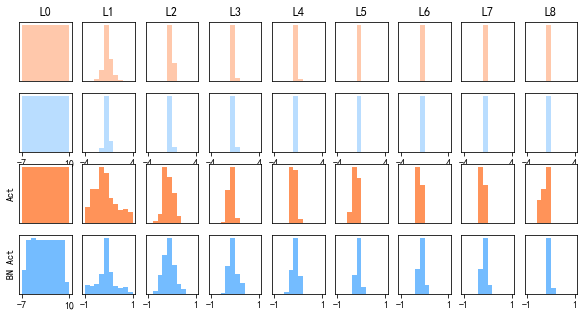

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11


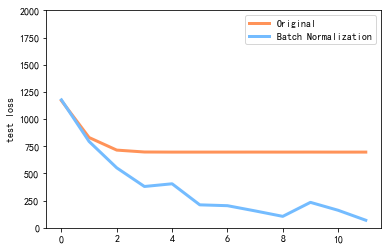

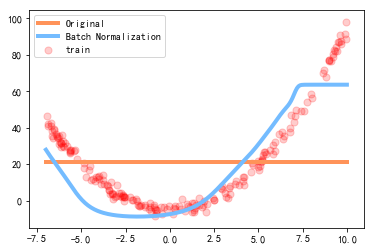

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    f, axs = plt.subplots(4, N_HIDDEN + 1, figsize=(10, 5))
    plt.ion()
    
    losses = [[], []]   # record test loss
    for epoch in range(EPOCH):
        print('Epoch: ', epoch)
        np.random.shuffle(train_data)
        step = 0
        in_epoch = True
        while in_epoch:
            b_s, b_f = (step*BATCH_SIZE) % len(train_data), ((step+1)*BATCH_SIZE) % len(train_data) # batch index
            step += 1
            if b_f < b_s:
                b_f = len(train_data)
                in_epoch = False
            b_x, b_y = train_data[b_s: b_f, 0:1], train_data[b_s: b_f, 1:2]         # batch training data
            sess.run([nets[0].train, nets[1].train], {tf_x: b_x, tf_y: b_y, tf_is_train: True})     # train

            if step == 1:
                l0, l1, l_in, l_in_bn, pa, pa_bn = sess.run(
                    [nets[0].loss, nets[1].loss, nets[0].layer_input, nets[1].layer_input,
                     nets[0].pre_activation, nets[1].pre_activation],
                    {tf_x: test_x, tf_y: test_y, tf_is_train: False})
                [loss.append(l) for loss, l in zip(losses, [l0, l1])]   # recode test loss
                plot_histogram(l_in, l_in_bn, pa, pa_bn)     # plot histogram
                
    # plot test loss
    plt.figure(2)
    plt.plot(losses[0], c='#FF9359', lw=3, label='Original')
    plt.plot(losses[1], c='#74BCFF', lw=3, label='Batch Normalization')
    plt.ylabel('test loss'); plt.ylim((0, 2000)); plt.legend(loc='best')

    # plot prediction line
    pred, pred_bn = sess.run([nets[0].out, nets[1].out], {tf_x: test_x, tf_is_train: False})
    plt.figure(3)
    plt.plot(test_x, pred, c='#FF9359', lw=4, label='Original')
    plt.plot(test_x, pred_bn, c='#74BCFF', lw=4, label='Batch Normalization')
    plt.scatter(x[:200], y[:200], c='r', s=50, alpha=0.2, label='train')
    plt.legend(loc='best'); plt.show()